In [20]:
# Dependencies and Setup
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from contextlib import redirect_stdout
import shap
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import os


In [3]:
pd.set_option('display.max_columns', None)

dementia_df = pd.read_csv("../Resources/dementia_patients_health_data.csv")
dementia_df


,Diabetic,AlcoholLevel,HeartRate,BloodOxygenLevel,BodyTemperature,Weight,MRI_Delay,Prescription,Dosage in mg,Age,Education_Level,Dominant_Hand,Gender,Family_History,Smoking_Status,APOE_ε4,Physical_Activity,Depression_Status,Cognitive_Test_Scores,Medication_History,Nutrition_Diet,Sleep_Quality,Chronic_Health_Conditions,Dementia
0,1,0.084974,98,96.230743,36.224852,57.563978,36.421028,NaN,NaN,60,Primary School,Left,Female,No,Current Smoker,Negative,Sedentary,No,10,No,Low-Carb Diet,Poor,Diabetes,0
1,0,0.016973,78,93.032122,36.183874,56.832335,31.157633,Galantamine,12.0,61,Secondary School,Right,Male,No,Former Smoker,Positive,Moderate Activity,No,1,Yes,Low-Carb Diet,Poor,Heart Disease,1
2,0,0.009000,89,93.566504,37.326321,59.759066,37.640435,NaN,NaN,69,Primary School,Right,Male,Yes,Former Smoker,Negative,Moderate Activity,No,8,No,Mediterranean Diet,Poor,Heart Disease,0
3,0,0.086437,60,93.906510,37.030620,58.266471,50.673992,Donepezil,23.0,78,Secondary School,Left,Female,Yes,Never Smoked,Negative,Mild Activity,Yes,5,Yes,Balanced Diet,Poor,Hypertension,1
4,1,0.150747,67,97.508994,36.062121,67.705027,27.810601,Memantine,20.0,77,Secondary School,Right,Male,Yes,Never Smoked,Positive,Mild Activity,No,0,Yes,Low-Carb Diet,Good,Diabetes,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,0.081825,87,93.851963,36.495134,50.380106,42.318663,Donepezil,10.0,88,Diploma/Degree,Left,Male,Yes,Never Smoked,Positive,Mild Activity,No,5,No,Balanced Diet,Poor,Diabetes,1
996,1,0.145249,97,94.522391,36.270804,94.006484,52.812568,NaN,NaN,80,Primary School,Left,Female,No,Never Smoked,Negative,Moderate Activity,No,9,Yes,Low-Carb Diet,Poor,Diabetes,0
997,1,0.073692,65,98.578388,37.065703,80.088613,13.640229,NaN,NaN,67,Primary School,Right,Female,No,Never Smoked,Positive,Sedentary,No,8,Yes,Balanced Diet,Good,Diabetes,0
998,0,0.037347,71,91.298580,37.037202,95.322210,17.445715,Memantine,20.0,62,No School,Left,Male,Yes,Never Smoked,Positive,Sedentary,Yes,2,No,Low-Carb Diet,Good,NaN,1


# Preprocessing the Data

In [4]:
# Drop unimportant 'Prescription' and 'Dosage in mg' columns
dementia_df.drop(columns=['Prescription', 'Dosage in mg'], inplace=True)
dementia_df.head()

,Diabetic,AlcoholLevel,HeartRate,BloodOxygenLevel,BodyTemperature,Weight,MRI_Delay,Age,Education_Level,Dominant_Hand,Gender,Family_History,Smoking_Status,APOE_ε4,Physical_Activity,Depression_Status,Cognitive_Test_Scores,Medication_History,Nutrition_Diet,Sleep_Quality,Chronic_Health_Conditions,Dementia
0,1,0.084974,98,96.230743,36.224852,57.563978,36.421028,60,Primary School,Left,Female,No,Current Smoker,Negative,Sedentary,No,10,No,Low-Carb Diet,Poor,Diabetes,0
1,0,0.016973,78,93.032122,36.183874,56.832335,31.157633,61,Secondary School,Right,Male,No,Former Smoker,Positive,Moderate Activity,No,1,Yes,Low-Carb Diet,Poor,Heart Disease,1
2,0,0.009000,89,93.566504,37.326321,59.759066,37.640435,69,Primary School,Right,Male,Yes,Former Smoker,Negative,Moderate Activity,No,8,No,Mediterranean Diet,Poor,Heart Disease,0
3,0,0.086437,60,93.906510,37.030620,58.266471,50.673992,78,Secondary School,Left,Female,Yes,Never Smoked,Negative,Mild Activity,Yes,5,Yes,Balanced Diet,Poor,Hypertension,1
4,1,0.150747,67,97.508994,36.062121,67.705027,27.810601,77,Secondary School,Right,Male,Yes,Never Smoked,Positive,Mild Activity,No,0,Yes,Low-Carb Diet,Good,Diabetes,1


In [5]:
# Encoding the binary columns using a custom function
binary_cols = ["Dominant_Hand", "Gender", "Family_History", "APOE_ε4", "Depression_Status", "Medication_History", "Sleep_Quality"]

def encode_binary(bin):
    if bin in ("Left", "Female", "Yes", "Positive", "Good"):
        return 1
    else:
        return 0

# Call the encode_binary function on the binary columns
for col in binary_cols:
    dementia_df[col] = dementia_df[col].apply(encode_binary)
dementia_df.head()

,Diabetic,AlcoholLevel,HeartRate,BloodOxygenLevel,BodyTemperature,Weight,MRI_Delay,Age,Education_Level,Dominant_Hand,Gender,Family_History,Smoking_Status,APOE_ε4,Physical_Activity,Depression_Status,Cognitive_Test_Scores,Medication_History,Nutrition_Diet,Sleep_Quality,Chronic_Health_Conditions,Dementia
0,1,0.084974,98,96.230743,36.224852,57.563978,36.421028,60,Primary School,1,1,0,Current Smoker,0,Sedentary,0,10,0,Low-Carb Diet,0,Diabetes,0
1,0,0.016973,78,93.032122,36.183874,56.832335,31.157633,61,Secondary School,0,0,0,Former Smoker,1,Moderate Activity,0,1,1,Low-Carb Diet,0,Heart Disease,1
2,0,0.009000,89,93.566504,37.326321,59.759066,37.640435,69,Primary School,0,0,1,Former Smoker,0,Moderate Activity,0,8,0,Mediterranean Diet,0,Heart Disease,0
3,0,0.086437,60,93.906510,37.030620,58.266471,50.673992,78,Secondary School,1,1,1,Never Smoked,0,Mild Activity,1,5,1,Balanced Diet,0,Hypertension,1
4,1,0.150747,67,97.508994,36.062121,67.705027,27.810601,77,Secondary School,0,0,1,Never Smoked,1,Mild Activity,0,0,1,Low-Carb Diet,1,Diabetes,1


In [6]:
# Convert categorical data to numeric with `pd.get_dummies`
categorical_cols = dementia_df.columns.drop(labels=['Diabetic', 'AlcoholLevel', 'HeartRate', 'BloodOxygenLevel', 'BodyTemperature', 'Weight', 'MRI_Delay', 'Age', 'Cognitive_Test_Scores', 'Dementia'] + binary_cols)
for col in categorical_cols:
    dementia_df = pd.concat([dementia_df, pd.get_dummies(dementia_df[col])], axis=1)
    dementia_df.drop(columns=col, inplace=True)

dementia_df.head()

,Diabetic,AlcoholLevel,HeartRate,BloodOxygenLevel,BodyTemperature,Weight,MRI_Delay,Age,Dominant_Hand,Gender,Family_History,APOE_ε4,Depression_Status,Cognitive_Test_Scores,Medication_History,Sleep_Quality,Dementia,Diploma/Degree,No School,Primary School,Secondary School,Current Smoker,Former Smoker,Never Smoked,Mild Activity,Moderate Activity,Sedentary,Balanced Diet,Low-Carb Diet,Mediterranean Diet,Diabetes,Heart Disease,Hypertension
0,1,0.084974,98,96.230743,36.224852,57.563978,36.421028,60,1,1,0,0,0,10,0,0,0,False,False,True,False,True,False,False,False,False,True,False,True,False,True,False,False
1,0,0.016973,78,93.032122,36.183874,56.832335,31.157633,61,0,0,0,1,0,1,1,0,1,False,False,False,True,False,True,False,False,True,False,False,True,False,False,True,False
2,0,0.009000,89,93.566504,37.326321,59.759066,37.640435,69,0,0,1,0,0,8,0,0,0,False,False,True,False,False,True,False,False,True,False,False,False,True,False,True,False
3,0,0.086437,60,93.906510,37.030620,58.266471,50.673992,78,1,1,1,0,1,5,1,0,1,False,False,False,True,False,False,True,True,False,False,True,False,False,False,False,True
4,1,0.150747,67,97.508994,36.062121,67.705027,27.810601,77,0,0,1,1,0,0,1,1,1,False,False,False,True,False,False,True,True,False,False,False,True,False,True,False,False


In [7]:
# Drop 'Diabetes' column as it duplicates the 'Diabetic' column
print(dementia_df[['Diabetic', 'Diabetes']].value_counts())
dementia_df.drop(columns='Diabetes', inplace=True)
dementia_df.head()

Diabetic  Diabetes
1         True        513
0         False       487
Name: count, dtype: int64


,Diabetic,AlcoholLevel,HeartRate,BloodOxygenLevel,BodyTemperature,Weight,MRI_Delay,Age,Dominant_Hand,Gender,Family_History,APOE_ε4,Depression_Status,Cognitive_Test_Scores,Medication_History,Sleep_Quality,Dementia,Diploma/Degree,No School,Primary School,Secondary School,Current Smoker,Former Smoker,Never Smoked,Mild Activity,Moderate Activity,Sedentary,Balanced Diet,Low-Carb Diet,Mediterranean Diet,Heart Disease,Hypertension
0,1,0.084974,98,96.230743,36.224852,57.563978,36.421028,60,1,1,0,0,0,10,0,0,0,False,False,True,False,True,False,False,False,False,True,False,True,False,False,False
1,0,0.016973,78,93.032122,36.183874,56.832335,31.157633,61,0,0,0,1,0,1,1,0,1,False,False,False,True,False,True,False,False,True,False,False,True,False,True,False
2,0,0.009000,89,93.566504,37.326321,59.759066,37.640435,69,0,0,1,0,0,8,0,0,0,False,False,True,False,False,True,False,False,True,False,False,False,True,True,False
3,0,0.086437,60,93.906510,37.030620,58.266471,50.673992,78,1,1,1,0,1,5,1,0,1,False,False,False,True,False,False,True,True,False,False,True,False,False,False,True
4,1,0.150747,67,97.508994,36.062121,67.705027,27.810601,77,0,0,1,1,0,0,1,1,1,False,False,False,True,False,False,True,True,False,False,False,True,False,False,False


In [8]:
# Assign target variable and features
y = dementia_df['Dementia']
X = dementia_df.drop(columns='Dementia')

# Split training/test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3)

In [9]:
# Preprocess numerical data for neural network

# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Deep Learning Model

In [9]:
# Create a method that creates a new Sequential model with hyperparameter options
def create_model(hp):
    nn_model = tf.keras.models.Sequential()

    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation',['relu', 'leaky_relu'])
    activation_last = hp.Choice('activation_last',['sigmoid', 'tanh'])
    
    # Allow kerastuner to decide number of neurons in first layer
    nn_model.add(tf.keras.layers.Dense(units=hp.Int('first_units',
        min_value=1,
        max_value=500,
        step=5), activation=activation, input_dim=len(X_train.columns)))

    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 10)):
        nn_model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
            min_value=1,
            max_value=500,
            step=5),
            activation=activation))
    
    nn_model.add(tf.keras.layers.Dense(units=1, activation=activation_last))

    # Compile the model
    nn_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
    
    return nn_model

In [10]:
# Import the kerastuner library
import keras_tuner as kt

tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",
    max_epochs=20,
    hyperband_iterations=2,
    directory=os.path.normpath('C:/'),
    project_name='dementia_keras_tuner',
    overwrite=True)

In [11]:
# Run the kerastuner search for best hyperparameters
tuner.search(X_train_scaled,y_train,epochs=20,validation_data=(X_test_scaled,y_test))

Trial 60 Complete [00h 00m 04s]
val_accuracy: 0.9800000190734863

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 02m 51s


In [12]:
# Get top 10 model hyperparameters and print the values
from pprint import pprint
top_hps = tuner.get_best_hyperparameters(10)
for param in top_hps:
    pprint(param.values)
    print('-'*40)

{'activation': 'leaky_relu',
 'activation_last': 'sigmoid',
 'first_units': 486,
 'num_layers': 2,
 'tuner/bracket': 2,
 'tuner/epochs': 20,
 'tuner/initial_epoch': 7,
 'tuner/round': 2,
 'tuner/trial_id': '0012',
 'units_0': 301,
 'units_1': 1,
 'units_2': 161,
 'units_3': 116,
 'units_4': 76,
 'units_5': 311,
 'units_6': 96,
 'units_7': 441,
 'units_8': 111,
 'units_9': 146}
----------------------------------------
{'activation': 'leaky_relu',
 'activation_last': 'sigmoid',
 'first_units': 486,
 'num_layers': 2,
 'tuner/bracket': 2,
 'tuner/epochs': 7,
 'tuner/initial_epoch': 3,
 'tuner/round': 1,
 'tuner/trial_id': '0000',
 'units_0': 301,
 'units_1': 1,
 'units_2': 161,
 'units_3': 116,
 'units_4': 76,
 'units_5': 311,
 'units_6': 96,
 'units_7': 441,
 'units_8': 111,
 'units_9': 146}
----------------------------------------
{'activation': 'leaky_relu',
 'activation_last': 'sigmoid',
 'first_units': 486,
 'num_layers': 2,
 'tuner/bracket': 2,
 'tuner/epochs': 3,
 'tuner/initial_epo

In [13]:
# Evaluate the top 3 models against the test dataset
top_models = tuner.get_best_models(3)
for model in top_models:
    model_loss, model_accuracy = model.evaluate(X_test_scaled,y_test,verbose=2)
    print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")
    print('-'*80)

8/8 - 0s - loss: 0.0180 - accuracy: 1.0000 - 205ms/epoch - 26ms/step
Loss: 0.017977191135287285, Accuracy: 1.0
--------------------------------------------------------------------------------
8/8 - 0s - loss: 0.0227 - accuracy: 0.9960 - 209ms/epoch - 26ms/step
Loss: 0.02272522822022438, Accuracy: 0.9959999918937683
--------------------------------------------------------------------------------
8/8 - 0s - loss: 0.0465 - accuracy: 0.9920 - 200ms/epoch - 25ms/step
Loss: 0.04649391397833824, Accuracy: 0.9919999837875366
--------------------------------------------------------------------------------


In [14]:
best_model = tuner.get_best_models()[0]
best_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 486)               15552     
                                                                 
 dense_1 (Dense)             (None, 301)               146587    
                                                                 
 dense_2 (Dense)             (None, 1)                 302       
                                                                 
 dense_3 (Dense)             (None, 1)                 2         
                                                                 
Total params: 162443 (634.54 KB)
Trainable params: 162443 (634.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
# Save the model's summary to a txt file (Uncomment if new model is generated)
# with open('best_model_summary.txt', 'w') as f:
#     with redirect_stdout(f):
#         best_model.summary()

In [16]:
#Predict
best_hps=tuner.get_best_hyperparameters()[0]

# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
hypermodel = tuner.hypermodel.build(best_hps)
history = hypermodel.fit(X_train_scaled, y_train, epochs=50)

val_acc_per_epoch = history.history['accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
24/24 [==============================] - 1s 3ms/step - loss: 0.4407 - accuracy: 0.8680
Epoch 2/50
24/24 [==============================] - 0s 3ms/step - loss: 0.1691 - accuracy: 0.9747
Epoch 3/50
24/24 [==============================] - 0s 3ms/step - loss: 0.0668 - accuracy: 0.9920
Epoch 4/50
24/24 [==============================] - 0s 3ms/step - loss: 0.0457 - accuracy: 0.9893
Epoch 5/50
24/24 [==============================] - 0s 3ms/step - loss: 0.0262 - accuracy: 0.9973
Epoch 6/50
24/24 [==============================] - 0s 3ms/step - loss: 0.0161 - accuracy: 1.0000
Epoch 7/50
24/24 [==============================] - 0s 3ms/step - loss: 0.0107 - accuracy: 1.0000
Epoch 8/50
24/24 [==============================] - 0s 3ms/step - loss: 0.0078 - accuracy: 1.0000
Epoch 9/50
24/24 [==============================] - 0s 3ms/step - loss: 0.0062 - accuracy: 1.0000
Epoch 10/50
24/24 [==============================] - 0s 3ms/step - loss: 0.0045 - accuracy: 1.0000
Epoch 11/50
24/24 [

In [17]:
# Evaluate the model using the test data
model_loss, model_accuracy = hypermodel.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

8/8 - 0s - loss: 0.0240 - accuracy: 0.9920 - 134ms/epoch - 17ms/step
Loss: 0.023972386494278908, Accuracy: 0.9919999837875366


In [18]:
# Save the model to a h5 file (Uncomment if new model is generated)
# best_model.save('dementia_predictor.h5')

# Random Forest Model

In [10]:
# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=1000, random_state=3)

In [11]:
# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

In [12]:
# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)

In [13]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [21]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,126,0
Actual 1,0,124


Accuracy Score : 1.0
Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       126
           1       1.00      1.00      1.00       124

    accuracy                           1.00       250
   macro avg       1.00      1.00      1.00       250
weighted avg       1.00      1.00      1.00       250



In [15]:
# Random Forests in sklearn will automatically calculate feature importance
importances = rf_model.feature_importances_
# We can sort the features by their importance
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(0.5920090528631993, 'Cognitive_Test_Scores'),
 (0.13571141667451173, 'Depression_Status'),
 (0.06474729721403304, 'APOE_ε4'),
 (0.02509545817676785, 'Current Smoker'),
 (0.020600024896541454, 'BloodOxygenLevel'),
 (0.018893237810766118, 'BodyTemperature'),
 (0.0180877976486805, 'Weight'),
 (0.017452934260315627, 'MRI_Delay'),
 (0.01743517621861152, 'AlcoholLevel'),
 (0.015113639838102405, 'Age'),
 (0.013427036374814922, 'HeartRate'),
 (0.007822157105975502, 'Former Smoker'),
 (0.005279363978884864, 'No School'),
 (0.004376496607980366, 'Diploma/Degree'),
 (0.003970257917908745, 'Never Smoked'),
 (0.0036148691385142614, 'Family_History'),
 (0.0029450014793867374, 'Sleep_Quality'),
 (0.00282960754464536, 'Dominant_Hand'),
 (0.0027531188943438227, 'Mild Activity'),
 (0.002750800723459244, 'Hypertension'),
 (0.002538778326968001, 'Gender'),
 (0.0024467324829678433, 'Diabetic'),
 (0.0023969924759190686, 'Primary School'),
 (0.002374546268245309, 'Medication_History'),
 (0.0023208230628236

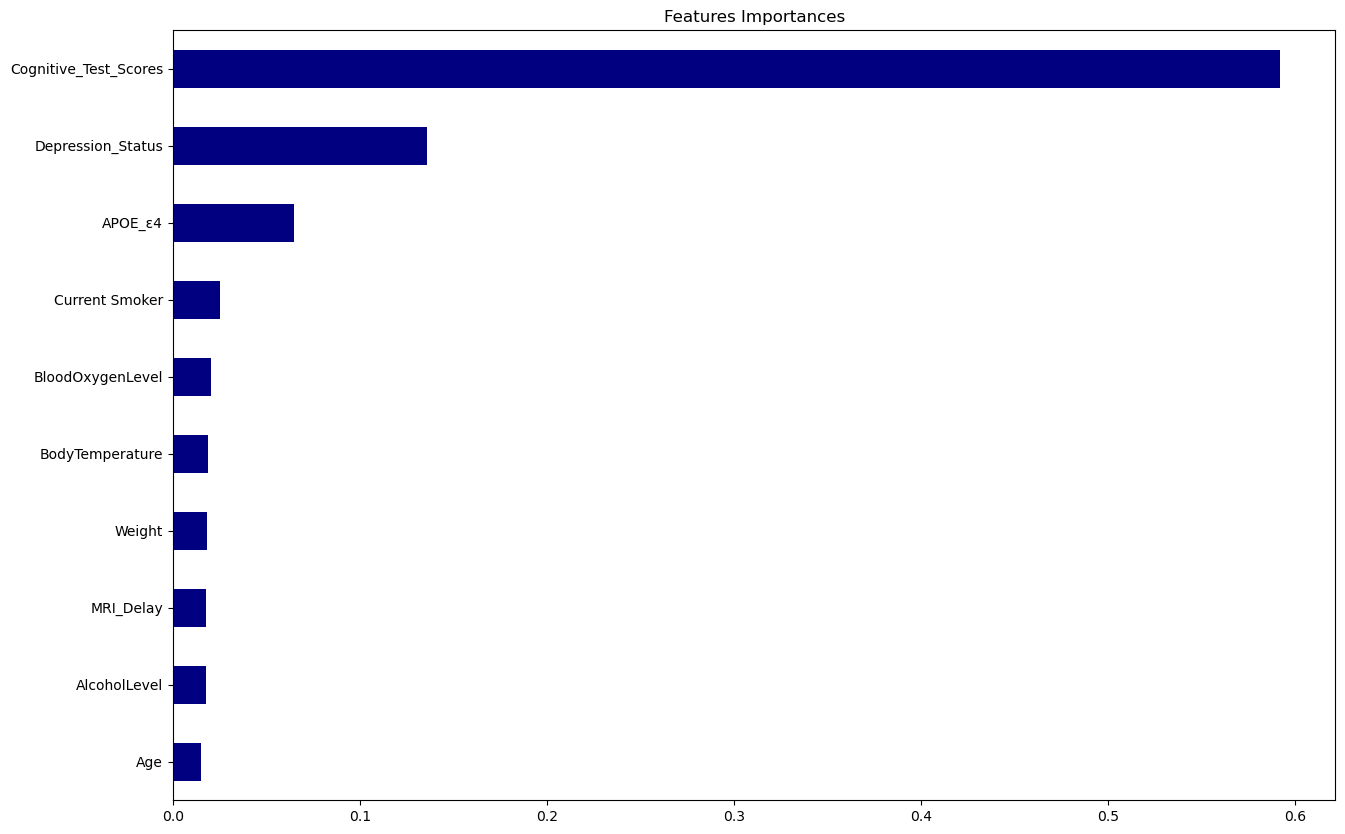

In [16]:
# Visualize the features by importance and save the graph as a JPG file
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances').tail(10)
importances_sorted.plot(kind='barh', color='navy', ylabel='', title= 'Features Importances', legend=False, figsize=(15,10)).get_figure().savefig('features_importances_top10.jpg')

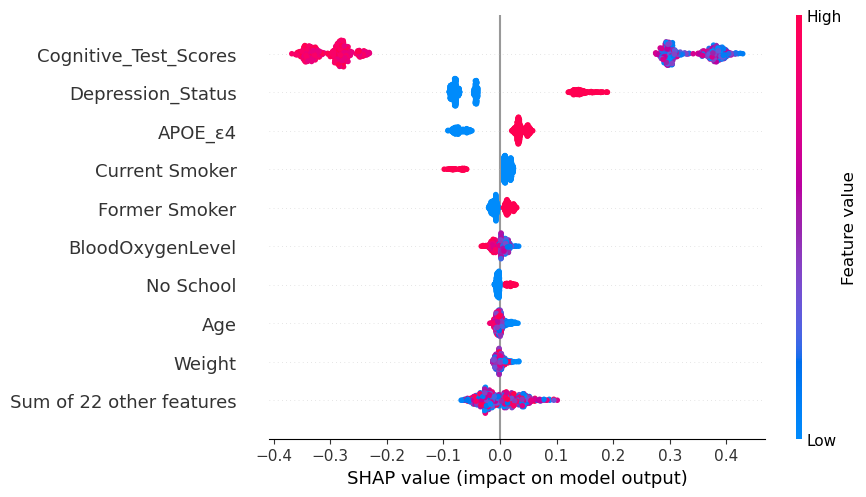

In [45]:
# Graph the SHAP values of the model with the explainer
explainer = shap.Explainer(rf_model, feature_names=X.columns)
shap_values = explainer(X_train_scaled)
shap.plots.beeswarm(shap_values[:,:,1])
plt.show()

# Logistic Regression Model

In [17]:
# Declare a logistic regression model
logistic_regression_model = LogisticRegression(random_state=3)

# Fit and save the logistic regression model using the training data
lr_model = logistic_regression_model.fit(X_train_scaled, y_train)

In [18]:
# Generate predictions
lr_predictions = logistic_regression_model.predict(X_test_scaled)

# Create and save the confusion matrix for predictions
lr_matrix = confusion_matrix(y_test, lr_predictions)

# Print the confusion matrix for the predictions
lr_cm_df = pd.DataFrame(
    lr_matrix, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
lr_acc_score = accuracy_score(y_test, lr_predictions)

In [19]:
# Displaying results
print("Confusion Matrix")
display(lr_cm_df)
print(f"Accuracy Score : {lr_acc_score}")
print("Classification Report")
print(classification_report(y_test, lr_predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,126,0
Actual 1,3,121


Accuracy Score : 0.988
Classification Report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       126
           1       1.00      0.98      0.99       124

    accuracy                           0.99       250
   macro avg       0.99      0.99      0.99       250
weighted avg       0.99      0.99      0.99       250

